In [2]:
%matplotlib inline
from lrgsglib.core import *
move_to_rootf(True)

Current working directory: /home/opisthofulax/PhD/projects/complex-networks/lrgsglib


### Small world Lattice 2D

In [13]:
side = 16
prew = 0.05
pflip = 0.1

In [14]:
l_sw = Lattice2D(side, prew=prew)

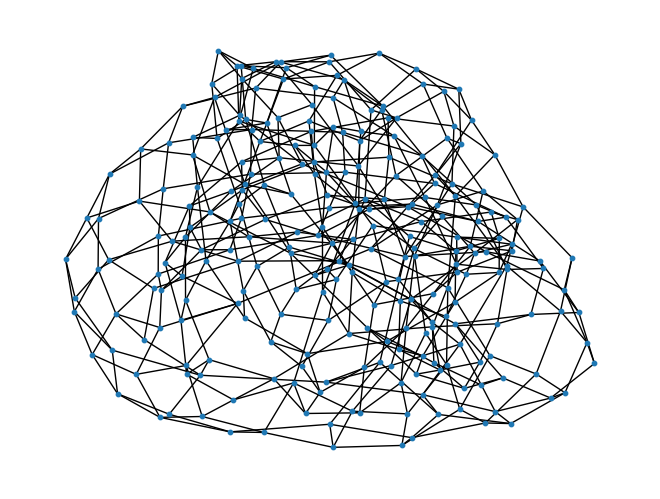

In [15]:
nx.draw(l_sw.G, node_size=10)

# Trash

In [2]:
pflip = 0.25
side1 = 32

In [3]:
l = Lattice2D(side1, pflip=pflip)
l.flip_sel_edges(l.fleset['G'])
l.compute_k_eigvV(MODE_dynspec="numpy")

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

arr = l.eigV[0].reshape(*l.syshape)
compound_log_array = np.where(arr > 0, -np.log(arr), 
                              np.where(arr < 0, np.log(-arr), arr))

im = ax1.imshow(arr)
ax1.set_title(r"$|\lambda_0\rangle$")
plt.colorbar(im, ax=ax1)
im = ax2.imshow(compound_log_array)
ax2.set_title(r"$-\log(|\lambda_0^+\rangle)+\log(-|\lambda_0^-\rangle)$")
plt.colorbar(im, ax=ax2)
im = ax3.imshow(l.bin_eigV().reshape(*l.syshape))
ax3.set_title(r"$\mathrm{sign}(|\lambda_0\rangle)$")
plt.colorbar(im, ax=ax3)
plt.suptitle(f"Eigenvector 0 - p={pflip}")

In [ ]:
cmap = plt.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, len(l.eigv[:100])))
ff = [l.compute_rbim_energy_eigV(_) for _ in range(100)]

In [ ]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
# Plot each horizontal line with a different color
for value, value2, color in zip(l.eigv[:100], ff, colors):
    ax1.axhline(value, color=color)
    ax2.axhline(value2, color=color)
ax1.set_yscale('log')
plt.show()

In [ ]:
eigvlist = []
for i in range(100):
    l = Lattice2D(side1, pflip=0.5, seed=i)
    l.flip_sel_edges(l.fleset['G'])
    l.compute_k_eigvV()
    eigV = l.bin_eigV().reshape(*l.syshape)
    eigvlist.append(eigV)

In [ ]:
plt.imshow(eigvlist[40])

In [ ]:
from itertools import combinations
def calculate_overlap(arr1, arr2):
    return np.sum(arr1 == arr2)
overlaps = []
for (arr1, arr2) in combinations(eigvlist, 2):
    overlaps.append(calculate_overlap(arr1, arr2))

In [ ]:
plt.hist(overlaps, bins=30, edgecolor='black')

In [ ]:
test = pk.load(open('data/l2d_squared/lrgsg/N=4096/pCluster_p=0.103_randZERR_na=500_test01.pkl', 'rb'))

In [ ]:
k,v  = unzip_dict_items(test)
arr = np.repeat(k, v)
x, pdf = powerlaw.pdf(arr, xmin=1)

In [ ]:
# plot
fig, ax = plt.subplots(figsize=(7, 3.5))
#
ax.loglog(x[1:], pdf, 'o')
ax.loglog(x[1:], x[1:]**(-2.05))
#
ax.set_xlabel(r"$S$")
ax.set_ylabel(r"$P(S)$")
#
fig.tight_layout()

In [ ]:
l = Lattice2D(32, geo='hexagonal', with_positions=True, pbc=False)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.set_aspect('equal')
nx.draw(l.G, ax=ax, pos=l.get_node_pos(), node_size=10, with_labels=False)

In [ ]:
def eigV_for_lattice(side, **kwargs):
    l = Lattice2D(side, **kwargs)
    l.flip_random_fract_edges()
    l.compute_k_eigvV(MODE_dynspec='scipy')
    return flip_to_positive_majority(l.eigV[0])
def create_symmetric_log_bins(min_val, max_val, num_bins, incMagn = 4):
    """Creates symmetric logarithmic bins."""
    bins_positive = np.logspace(np.log10(min_val)-incMagn, np.log10(max_val)+incMagn, num_bins//2)
    bins_negative = -np.flip(bins_positive)
    return np.concatenate((bins_negative, [0], bins_positive))

def bin_eigenvalues(eig_values, bins):
    """Bins eigenvalues and counts occurrences in each bin."""
    indices = np.digitize(eig_values, bins, right=True)
    return Counter(indices)

In [ ]:
# Get initial eigenvalues to define bins
initial_eig = eigV_for_lattice(side, pflip=pflip, geo=geo)
bins = create_symmetric_log_bins(np.min(np.abs(initial_eig)), np.max(np.abs(initial_eig)), bins_count)
bin_counter = Counter()

if not os.path.exists(fname):
    nAvgDone = 0
    fnameExists = glob.glob(f"{workDir}{fnameBase}*")
    if fnameExists:
        nAvgDone = int(os.path.splitext(fnameExists[0].split('_')[-1])[0])
    nAvgNeed = nAvg - nAvgDone
    fnameOld = fnameExists[0]
    for current_period in range((nAvgNeed // period) + bool(nAvgNeed % period)):
        batch_size = min(nAvgNeed - current_period * period, period)
        eig_values = np.concatenate([eigV_for_lattice(side, pflip=pflip, geo=geo) for _ in range(batch_size)])
        bin_counter.update(bin_eigenvalues(eig_values, bins))
        fnameNew = f"{workDir}{fnameBase}_{nAvgDone + (current_period + 1) * period}.pkl"
        try:
            os.rename(fnameOld, fnameNew)
        except FileNotFoundError:
            pass
        with open(fnameNew, "wb") as f:
            pk.dump(dict(bin_counter), f)
        fnameOld = f"{workDir}{fnameBase}_{nAvgDone + current_period * period}.pkl" if current_period > 0 else ""

    # At the end, save the final state if needed
    if nAvgNeed % period:
        fnameNew = f"{workDir}{fnameBase}_{nAvg}.pkl"
        with open(fnameNew, "wb") as f:
            pk.dump(dict(bin_counter), f)


In [ ]:
k,v = zip(*pk.load(open(f"{workDir}{fnameBase}_{nAvg}.pkl", "rb")).items())
binsv = bins[np.array(k)-1]
zero_index = np.where(binsv > 0)[0][0]
negative_values = v[:zero_index]
positive_values = v[zero_index:]
plt.plot(binsv, v, 'o')
# plt.axhline(np.max(positive_values))
# plt.axhline(np.max(negative_values))

plt.xscale('symlog', linthresh=1e-17)
plt.yscale('log')


In [ ]:
negative_values, zero_index, np.where(binsv < 0), binsv

In [ ]:
l = Lattice2D(128, pflip=0.01)
l.flip_random_fract_edges()
l.compute_k_eigvV()
outp, outm = symlog_binning(flip_to_positive_majority(l.eigV[0]))

In [ ]:
plt.plot(outp[0], outp[1], 'o-')
plt.plot(outm[0], outm[1], 'o-')

In [ ]:
nAvg = 1000
pflip = 0.05
side = 16
geo = 'squared'

period = 20
freq = period**(-1)
workDir = "test/"
fnameBase = "tmp"
fname = f"{workDir}{fnameBase}_{nAvg}.pkl"

if not os.path.exists(fname):
    nAvgDone = 0
    flist = os.listdir(workDir)
    fnameExists = glob.glob(f"{workDir}{fnameBase}*")
    if len(fnameExists) > 1:
        print(f"Multiple files found for {fnameBase}")
        print(fnameExists)
        exit()
    else:
        if fnameExists:
            nAvgDone = int(os.path.splitext(fnameExists[0].split('_')[-1])[0])
            print(nAvgDone)
    nAvgNeed = nAvg - nAvgDone
    #
    lEigV = []
    print(fnameExists)
    fnameOld = fnameExists[0] if nAvgDone else ""
    if nAvgNeed < period:
        lEigV = [eigV_for_lattice(side, pflip=pflip, geo=geo) 
                 for i in range(nAvgNeed)]
        fnameNew = f"{workDir}{fnameBase}_{nAvg}.pkl"
        os.rename(fnameOld, fnameNew)
        with open(fname, "ab") as f:
            pk.dump(lEigV, f)
    else:
        for _ in range(period):
            lEigV = [eigV_for_lattice(side, pflip=pflip, geo=geo) 
                    for i in range(nAvgNeed//period)]
            fnameNew = f"{workDir}{fnameBase}_{nAvgDone+(_+1)*nAvgNeed//period}.pkl"
            try:
                os.rename(fnameOld, fnameNew)
            except FileNotFoundError:
                pass
            with open(fnameNew, "ab") as f:
                pk.dump(lEigV, f)
            fnameOld = f"{workDir}{fnameBase}_{nAvgDone+(_+1)*nAvgNeed//period}.pkl"
        if nAvgNeed%period:
            lEigV = [eigV_for_lattice(side, pflip=pflip, geo=geo) 
                    for i in range(nAvgNeed%period)]
            fnameNew = f"{workDir}{fnameBase}_{nAvg}.pkl"
            with open(fnameNew, "ab") as f:
                pk.dump(lEigV, f)

# for i in range(nAvg):
#     l = Lattice2D(side, pflip=pflip)
#     l.flip_random_fract_edges()
#     l.compute_k_eigvV()
#     lEigV.append(l.eigV[0])
#     with open(fname, "ab") as f:
#         pk.dump(, f)
#         f.flush()

In [ ]:
all_data = []
with open(fname, "rb") as f:
    # Loop until the end of the file
    while True:
        try:
            # Unpickle the next chunk of data and append it to the list
            data_chunk = pk.load(f)
            all_data.extend(data_chunk)
        except EOFError:
            # Reached the end of the file
            break

In [ ]:
all_data

In [ ]:
data.shape

In [ ]:
l = Lattice2D(side1=16,
              pflip=0.25,  
              pbc=False, 
              geo='hexagonal', 
              init_nw_dict=True, 
              with_positions=True)
l.flip_sel_edges(l.nwDict['randZERR']['G'])


In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_aspect('equal')
nx.draw(l.G, ax=ax, pos=nx.get_node_attributes(l.G, 'pos'), 
        node_size=40, 
        node_color=['red' if i in l.nwDict.rNodeFlip['G'] else 'blue' for i in l.G.nodes()],
        edgecolors='k', linewidths=1, width=2, 
        edge_color=['r' if w < 0 else 'blue' 
                    for u, v, w in list(l.G.edges(data='weight'))],
        # with_labels=True
        )